In [15]:
from matplotlib import pyplot as plt

import numpy as np

from fit.matrices.const_mats import create_p2d_mat
from fit.matrices.top_mats import create_top_mats
from fit.mesh.mesh import Mesh
from fit.solver.solve_poisson import solve_poisson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
## Generate mesh
n = 100
xmesh = np.linspace(0, 1, n)
ymesh = np.linspace(0, 1, n)
zmesh = np.linspace(0, 1, 2)
msh = Mesh(xmesh, ymesh, zmesh)

In [17]:
## Set boundary conditions
bc = np.full(msh.np, np.nan)
idx_bc_1 = np.concatenate([msh.idx(0, np.arange(n), 0), msh.idx(0, np.arange(n), 1)])
idx_bc_2 = np.concatenate([msh.idx(n-1, np.arange(n), 0), msh.idx(n-1, np.arange(n), 1)])
# bc[idx_bc_1] = 0
# bc[idx_bc_2] = 1  # TODO: Remove bc?

In [18]:
## Current excitation
g,_,_ = create_top_mats(msh)
i = np.zeros(3*msh.np)
i[msh.idx(int(n/2), int(n/2), 0) + 2*msh.np] = 1
f = -g.T @ i

In [19]:
## Solve system
eps = 8.854e-12
sig = 58e6
phi = solve_poisson(msh, f, sig, bc)

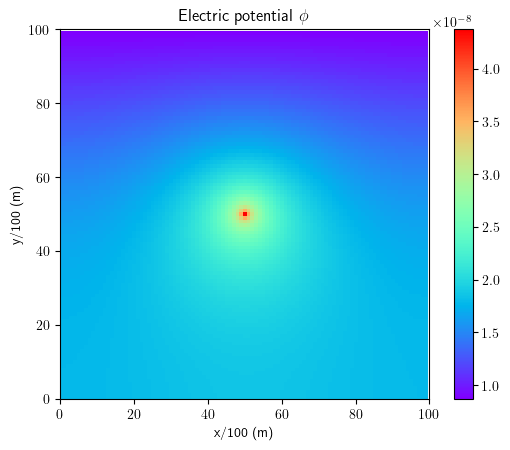

In [20]:
## Plot solution
phi_plot = np.reshape(phi, (msh.nz, msh.ny, msh.nx))
plt.rcParams['text.usetex'] = True
plt.imshow(phi_plot[0,:,:], cmap='rainbow')
plt.xlim([0, n])
plt.ylim([0, n])
plt.xlabel(f"x/{n} (m)")
plt.ylabel(f"y/{n} (m)")
plt.title("Electric potential $\phi$")
plt.colorbar()
plt.show()

In [21]:
## Power calculation
m_sig = create_p2d_mat(msh, sig)    # Conductivity matrix
u = -g@phi                          # Voltage vector
i = m_sig@g@phi                     # Current vector
pe = u*i                            # Power on edge vector
pv = 0.5*np.abs(g.T) @ pe           # Power on dual volume vector

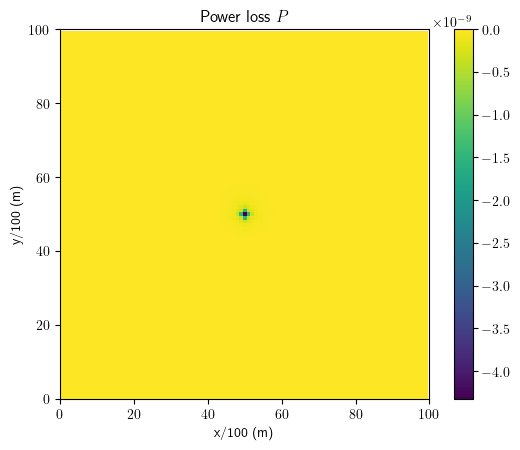

In [22]:
## Plot power
p_plot = np.reshape(pv, (msh.nz, msh.ny, msh.nx))
plt.imshow(p_plot[0,:,:], cmap='viridis')
plt.xlim([0, n])
plt.ylim([0, n])
plt.xlabel(f"x/{n} (m)")
plt.ylabel(f"y/{n} (m)")
plt.title("Power loss $P$")
plt.colorbar()
plt.show()